# Monthly hotel-room occupancy — raw exploration
We have three parallel series (high-tariff A, high-tariff B, medium-tariff).
All rates are percentages, so we convert them to proportions (`0 - 1`).



In [1]:
# %% [parameters] ------------------------------------------------------------
"""
Configuration
-------------
Nothing else in the notebook should need editing – just keep these paths / names
up-to-date if you move the file or rename columns in the source CSV.
"""
import pathlib, os

ROOT = pathlib.Path(os.getcwd()).resolve().parent  # project root
DATA_FILE = ROOT / "examples" / "data" / "hotel_room_occupancy_rate_monthly_by_cat_en.csv"

DATE_COL = "Year-Month"  # YYYYMM integer / string
VALUE_COLS = [
    "Hotel room occupancy rate of high tariff A hotels",
    "Hotel room occupancy rate  of high tariff B hotels",
    "Hotel room occupancy rate of medium tariff hotels"
]

# %% -------------------------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------- load & tidy ------------------------------------------------------
df = pd.read_csv(DATA_FILE)

# strip stray whitespace in *every* column name
df.columns = df.columns.str.strip()

# YYYYMM → pandas datetime (month-start index)
df["ds"] = pd.to_datetime(df[DATE_COL].astype(str), format="%Y%m", errors="raise")

# convert % → proportion
for col in VALUE_COLS:
    df[col] = df[col] / 100.0

# ensure all values are in the open interval (0,1)
if not ((df[VALUE_COLS] > 0) & (df[VALUE_COLS] < 1)).all().all():
    raise ValueError("Some occupancy rates fall outside (0, 1) – check the raw data!")

df = df.sort_values("ds").reset_index(drop=True)
display(df.head())

,Year-Month,Hotel room occupancy rate of high tariff A hotels,Hotel room occupancy rate of high tariff B hotels,Hotel room occupancy rate of medium tariff hotels,ds
0,202002,0.14,0.26,0.41,2020-02-01
1,202003,0.12,0.30,0.47,2020-03-01
2,202004,0.12,0.32,0.50,2020-04-01
3,202005,0.14,0.35,0.54,2020-05-01
4,202006,0.19,0.42,0.62,2020-06-01


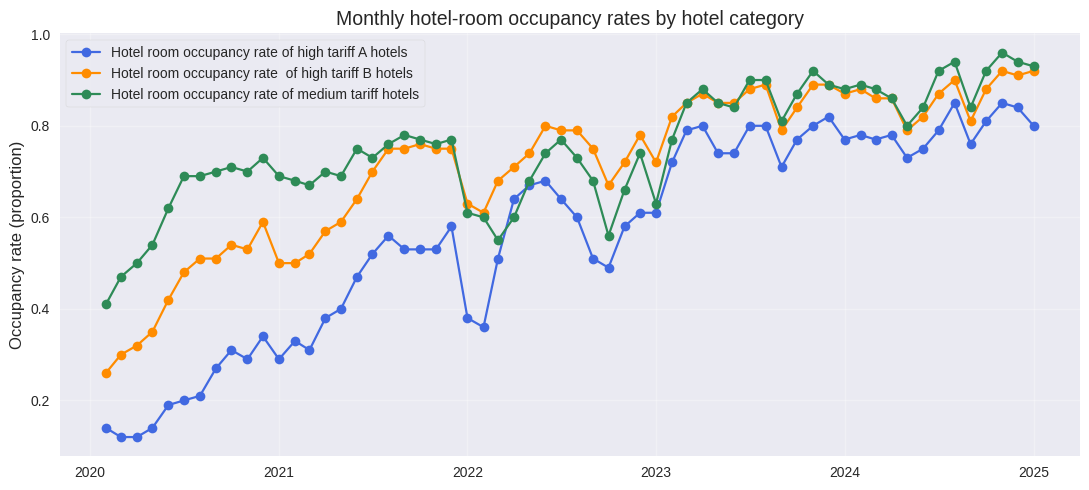

In [2]:

# --------- quick visual sanity-check ----------------------------------------
plt.style.use("seaborn-v0_8")
fig, ax = plt.subplots(figsize=(11, 5))  # Increased height for better visualization

col_colors = ["royalblue", "darkorange", "seagreen"]
for c, col in zip(col_colors, VALUE_COLS):
    ax.plot(df["ds"], df[col], marker="o", lw=1.6, label=col.strip(), color=c)

ax.set_ylabel("Occupancy rate (proportion)", fontsize=12)
ax.set_title("Monthly hotel-room occupancy rates by hotel category", fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend(frameon=True, loc='best')
fig.tight_layout()

In [3]:

# %%  -------------------------------------------------------------------------
# Choose the "high-tariff A" series and set up cross-validation
# --------------------------------------------------------------------------
TARGET_COL = "Hotel room occupancy rate of high tariff A hotels"

series = (
    df[["ds", TARGET_COL]].rename(columns={TARGET_COL: "y"})
    .assign(t=np.arange(len(df), dtype=float))
)

t_all, y_all = series["t"].to_numpy(), series["y"].to_numpy()

# --- rolling-origin CV windows ---------------------------------------------
INIT_MONTHS = 24  # first 1½ years = training
CV_HORIZON = 12  # forecast 3 months ahead each fold
CV_STEP = 9  # slide by 3 months
HOLD_OUT_MO = 9  # keep last 6 months for a final test

first_test = INIT_MONTHS
fold_starts = list(range(first_test,
                         len(series) - HOLD_OUT_MO - CV_HORIZON + 1,
                         CV_STEP))
print(f"{len(series)} rows  →  {len(fold_starts)} CV folds")

60 rows  →  2 CV folds


In [4]:

# --- Optuna settings ---------------------------------------------------------
SEED = 42
TRIALS_MUR = 50
TRIALS_PROP = 30

import numpy as np

rmse = lambda a, f: np.sqrt(np.mean((a - f) ** 2))

# %%  -------------------------------------------------------------------------
# Hyper-parameter spaces, CV objective, Optuna search, hold-out fit
# --------------------------------------------------------------------------
import optuna, warnings, time
from prophet import Prophet
from murphet import fit_churn_model


/home/halsted/anaconda3/envs/murphet2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [5]:

# --- search spaces -----------------------------------------------------------
def mur_cfg(trial):
    periods, harms = [12.0], [trial.suggest_int("harm_year", 1, 4)]
    if trial.suggest_categorical("add_half", [0, 1]):
        periods.append(6.0)
        harms.append(trial.suggest_int("harm_half", 1, 3))

    return dict(
        periods=periods,
        num_harmonics=harms,
        n_changepoints=trial.suggest_int("n_cp", 2, 12),
        delta_scale=trial.suggest_float("delta_scale", 0.02, 0.8, log=True),
        gamma_scale=trial.suggest_float("gamma_scale", 1.0, 10.0),
        season_scale=trial.suggest_float("season_scale", 0.4, 2.5),
        # ρ prior is fixed inside the Stan file; beta_phi is learned there too
        likelihood="beta",
        inference="map",
        chains=2,
        iter=4000,
        warmup=0,
        seed=SEED,
    )


# --- Prophet search space ------------------------------------------------
def prop_cfg(trial):
    return dict(
        # Prophet's *built-in* yearly — we expose only its Fourier order:
        yearly_fourier=trial.suggest_int("yearly_fourier", 3, 10),

        # changepoint & seasonality priors
        cp_scale=trial.suggest_float("cp_scale", 0.01, 0.5, log=True),
        sea_scale=trial.suggest_float("sea_scale", 0.1, 10.0, log=True),
    )


# --- CV objective ------------------------------------------------------------
def cv_objective(build_cfg, is_murphet):
    def _obj(trial):
        cfg, errs = build_cfg(trial), []

        for idx in fold_starts:
            tr_end, te_end = idx, idx + CV_HORIZON
            try:
                if is_murphet:  # Murphet branch
                    m = fit_churn_model(t=t_all[:tr_end],
                                        y=y_all[:tr_end],
                                        **cfg)
                    pred = m.predict(t_all[tr_end:te_end])

                else:  # Prophet branch
                    p = Prophet(
                        changepoint_prior_scale=cfg["cp_scale"],
                        seasonality_prior_scale=cfg["sea_scale"],
                        yearly_seasonality=cfg["yearly_fourier"],  # <- one line!
                        weekly_seasonality=False,
                        daily_seasonality=False,
                    )

                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        p.fit(series.iloc[:tr_end][["ds", "y"]])

                    fut = p.make_future_dataframe(
                        CV_HORIZON, freq="MS").iloc[-CV_HORIZON:]
                    pred = p.predict(fut)["yhat"].to_numpy()

                errs.append(rmse(y_all[tr_end:te_end], pred))

            except RuntimeError:  # e.g. Stan or fitting failure
                return 1e6

        return float(np.mean(errs))

    return _obj


In [6]:

# --- search Murphet ----------------------------------------------------------
mur_study = optuna.create_study(direction="minimize",
                                sampler=optuna.samplers.TPESampler(seed=SEED))
mur_study.optimize(cv_objective(mur_cfg, True),
                   n_trials=TRIALS_MUR, show_progress_bar=True)
best_mur = mur_cfg(mur_study.best_trial)

[I 2025-04-20 04:35:08,951] A new study created in memory with name: no-name-764241f8-8bba-4e07-a51e-6ad0ebbda123
  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-04-20 04:35:08,984] Trial 0 finished with value: 0.11715170754038948 and parameters: {'harm_year': 2, 'add_half': 0, 'n_cp': 8, 'delta_scale': 0.03556159383830237, 'gamma_scale': 2.403950683025824, 'season_scale': 0.5219755855532189}. Best is trial 0 with value: 0.11715170754038948.


Best trial: 0. Best value: 0.117152:   2%|▏         | 1/50 [00:00<00:04, 12.00it/s]/home/halsted/Documents/python/murphet/src/murphet/churn_model.py:645: UserWarning: Optimization failed: Error during optimization! Command '/home/halsted/.murphet_models/murphet_beta_8cf34b23 random seed=42 data file=/tmp/tmpnxn7u4g7/gvxs1ohy.json output file=/tmp/tmpnxn7u4g7/murphet_beta_8cf34b23ekzdhpjd/murphet_beta_8cf34b23-20250420043509.csv method=optimize algorithm=lbfgs iter=10000' failed: console log output: [...]. Trying alternative settings.
  warnings.warn(f"Optimization failed: {concise_error}. Trying alternative settings.")
/home/halsted/Documents/python/murphet/src/murphet/churn_model.py:660: UserWarning: Second optimization attempt also failed: Error during optimization! Command '/home/halsted/.murphet_models/murphet_beta_8cf34b23 random seed=42 data file=/tmp/tmpnxn7u4g7/zf5l1isw.json output file=/tmp/tmpnxn7u4g7/murphet_beta_8cf34b23_q0xmltq/murphet_beta_8cf34b23-20250420043509.csv meth

[I 2025-04-20 04:35:09,035] Trial 1 finished with value: 0.20556286167883864 and parameters: {'harm_year': 4, 'add_half': 1, 'harm_half': 1, 'n_cp': 12, 'delta_scale': 0.43117447730995384, 'gamma_scale': 2.9110519961044856, 'season_scale': 0.7818324311349114}. Best is trial 0 with value: 0.11715170754038948.
[I 2025-04-20 04:35:09,064] Trial 2 finished with value: 1000000.0 and parameters: {'harm_year': 1, 'add_half': 1, 'harm_half': 2, 'n_cp': 5, 'delta_scale': 0.19109751468217398, 'gamma_scale': 2.2554447458683766, 'season_scale': 1.0135037619239582}. Best is trial 0 with value: 0.11715170754038948.


Best trial: 0. Best value: 0.117152:  10%|█         | 5/50 [00:00<00:01, 26.70it/s]

[I 2025-04-20 04:35:09,098] Trial 3 finished with value: 0.1715719056339607 and parameters: {'harm_year': 2, 'add_half': 1, 'harm_half': 1, 'n_cp': 7, 'delta_scale': 0.17787449279672934, 'gamma_scale': 1.4180537144799796, 'season_scale': 1.6758441889930205}. Best is trial 0 with value: 0.11715170754038948.
[I 2025-04-20 04:35:09,121] Trial 4 finished with value: 0.11876104845048172 and parameters: {'harm_year': 1, 'add_half': 1, 'harm_half': 3, 'n_cp': 10, 'delta_scale': 0.06152328666462679, 'gamma_scale': 1.8790490260574548, 'season_scale': 1.8368893556755297}. Best is trial 0 with value: 0.11715170754038948.
[I 2025-04-20 04:35:09,142] Trial 5 finished with value: 0.1204443176534937 and parameters: {'harm_year': 2, 'add_half': 1, 'harm_half': 1, 'n_cp': 12, 'delta_scale': 0.05195305024387061, 'gamma_scale': 6.962700559185838, 'season_scale': 1.054593259787763}. Best is trial 0 with value: 0.11715170754038948.


Best trial: 0. Best value: 0.117152:  16%|█▌        | 8/50 [00:00<00:01, 30.62it/s]

[I 2025-04-20 04:35:09,184] Trial 6 finished with value: 0.14870870766595917 and parameters: {'harm_year': 3, 'add_half': 0, 'n_cp': 12, 'delta_scale': 0.3490111324600883, 'gamma_scale': 9.455490474077703, 'season_scale': 2.2791374358980625}. Best is trial 0 with value: 0.11715170754038948.
[I 2025-04-20 04:35:09,198] Trial 7 finished with value: 0.17666191502732118 and parameters: {'harm_year': 3, 'add_half': 0, 'n_cp': 4, 'delta_scale': 0.023631257130122117, 'gamma_scale': 3.927972976869379, 'season_scale': 1.2162223083479122}. Best is trial 0 with value: 0.11715170754038948.
[I 2025-04-20 04:35:09,223] Trial 8 finished with value: 0.13494358763481673 and parameters: {'harm_year': 2, 'add_half': 0, 'n_cp': 5, 'delta_scale': 0.1480681594456554, 'gamma_scale': 2.2683180247728636, 'season_scale': 2.0846136595834834}. Best is trial 0 with value: 0.11715170754038948.


Best trial: 0. Best value: 0.117152:  24%|██▍       | 12/50 [00:00<00:00, 38.29it/s]

[I 2025-04-20 04:35:09,236] Trial 9 finished with value: 0.1315716834249218 and parameters: {'harm_year': 1, 'add_half': 0, 'n_cp': 4, 'delta_scale': 0.02041158634996417, 'gamma_scale': 8.339152856093508, 'season_scale': 1.8844004220799961}. Best is trial 0 with value: 0.11715170754038948.
[I 2025-04-20 04:35:09,260] Trial 10 finished with value: 0.11804294675774957 and parameters: {'harm_year': 4, 'add_half': 0, 'n_cp': 8, 'delta_scale': 0.06151279603425915, 'gamma_scale': 4.580193116362997, 'season_scale': 0.4813229199184843}. Best is trial 0 with value: 0.11715170754038948.
[I 2025-04-20 04:35:09,287] Trial 11 finished with value: 0.11789331963788663 and parameters: {'harm_year': 4, 'add_half': 0, 'n_cp': 8, 'delta_scale': 0.056786265819044814, 'gamma_scale': 4.8418478155782445, 'season_scale': 0.4182616237249635}. Best is trial 0 with value: 0.11715170754038948.


Best trial: 12. Best value: 0.109688:  26%|██▌       | 13/50 [00:00<00:00, 38.29it/s]

[I 2025-04-20 04:35:09,312] Trial 12 finished with value: 0.10968796338531427 and parameters: {'harm_year': 3, 'add_half': 0, 'n_cp': 9, 'delta_scale': 0.039294699592287166, 'gamma_scale': 6.15961879886106, 'season_scale': 0.40885764551091985}. Best is trial 12 with value: 0.10968796338531427.
[I 2025-04-20 04:35:09,333] Trial 13 finished with value: 0.1653744191003856 and parameters: {'harm_year': 3, 'add_half': 0, 'n_cp': 10, 'delta_scale': 0.03057718966322393, 'gamma_scale': 6.481664770903699, 'season_scale': 0.7257026304594087}. Best is trial 12 with value: 0.10968796338531427.


Best trial: 12. Best value: 0.109688:  28%|██▊       | 14/50 [00:00<00:00, 38.29it/s]/home/halsted/Documents/python/murphet/src/murphet/churn_model.py:645: UserWarning: Optimization failed: Error during optimization! Command '/home/halsted/.murphet_models/murphet_beta_8cf34b23 random seed=42 data file=/tmp/tmpnxn7u4g7/d1hrpqit.json output file=/tmp/tmpnxn7u4g7/murphet_beta_8cf34b238a3pjvbk/murphet_beta_8cf34b23-20250420043509.csv method=optimize algorithm=lbfgs iter=10000' failed: console log output: [...]. Trying alternative settings.
  warnings.warn(f"Optimization failed: {concise_error}. Trying alternative settings.")
/home/halsted/Documents/python/murphet/src/murphet/churn_model.py:660: UserWarning: Second optimization attempt also failed: Error during optimization! Command '/home/halsted/.murphet_models/murphet_beta_8cf34b23 random seed=42 data file=/tmp/tmpnxn7u4g7/9u3jqjyw.json output file=/tmp/tmpnxn7u4g7/murphet_beta_8cf34b23japkvle7/murphet_beta_8cf34b23-20250420043509.csv me

[I 2025-04-20 04:35:09,402] Trial 14 finished with value: 0.35856114263461447 and parameters: {'harm_year': 3, 'add_half': 0, 'n_cp': 9, 'delta_scale': 0.7883303228651525, 'gamma_scale': 6.304038493042732, 'season_scale': 1.3902110624947888}. Best is trial 12 with value: 0.10968796338531427.
[I 2025-04-20 04:35:09,429] Trial 15 finished with value: 1000000.0 and parameters: {'harm_year': 2, 'add_half': 0, 'n_cp': 2, 'delta_scale': 0.08519792365724416, 'gamma_scale': 3.7615616097949713, 'season_scale': 0.708583610344474}. Best is trial 12 with value: 0.10968796338531427.


Best trial: 12. Best value: 0.109688:  34%|███▍      | 17/50 [00:00<00:00, 33.67it/s]

[I 2025-04-20 04:35:09,448] Trial 16 finished with value: 0.13646730592528586 and parameters: {'harm_year': 2, 'add_half': 0, 'n_cp': 10, 'delta_scale': 0.03606181179912452, 'gamma_scale': 7.99940443156247, 'season_scale': 0.4417993291713274}. Best is trial 12 with value: 0.10968796338531427.
[I 2025-04-20 04:35:09,483] Trial 17 finished with value: 0.1107028989246232 and parameters: {'harm_year': 3, 'add_half': 0, 'n_cp': 7, 'delta_scale': 0.09612798729490345, 'gamma_scale': 6.025107677373652, 'season_scale': 0.8558865318101696}. Best is trial 12 with value: 0.10968796338531427.


Best trial: 12. Best value: 0.109688:  40%|████      | 20/50 [00:00<00:00, 31.25it/s]

[I 2025-04-20 04:35:09,514] Trial 18 finished with value: 0.1248038820619069 and parameters: {'harm_year': 3, 'add_half': 0, 'n_cp': 6, 'delta_scale': 0.09888722938431965, 'gamma_scale': 5.176553698759932, 'season_scale': 0.9291155219387105}. Best is trial 12 with value: 0.10968796338531427.
[I 2025-04-20 04:35:09,574] Trial 19 finished with value: 0.1367766887341928 and parameters: {'harm_year': 4, 'add_half': 0, 'n_cp': 7, 'delta_scale': 0.10429875598134736, 'gamma_scale': 7.49322992228903, 'season_scale': 1.4152920224423424}. Best is trial 12 with value: 0.10968796338531427.


Best trial: 21. Best value: 0.107069:  42%|████▏     | 21/50 [00:00<00:00, 31.25it/s]

[I 2025-04-20 04:35:09,626] Trial 20 finished with value: 0.12262198961496351 and parameters: {'harm_year': 3, 'add_half': 0, 'n_cp': 2, 'delta_scale': 0.23661550277134524, 'gamma_scale': 9.554712980463407, 'season_scale': 1.2352504223921665}. Best is trial 12 with value: 0.10968796338531427.
[I 2025-04-20 04:35:09,647] Trial 21 finished with value: 0.10706945968325979 and parameters: {'harm_year': 3, 'add_half': 0, 'n_cp': 8, 'delta_scale': 0.0367071568533654, 'gamma_scale': 6.163205207550328, 'season_scale': 0.6556194302697}. Best is trial 21 with value: 0.10706945968325979.


Best trial: 21. Best value: 0.107069:  48%|████▊     | 24/50 [00:00<00:00, 32.34it/s]

[I 2025-04-20 04:35:09,667] Trial 22 finished with value: 0.1079431672997891 and parameters: {'harm_year': 3, 'add_half': 0, 'n_cp': 9, 'delta_scale': 0.043006641744616915, 'gamma_scale': 5.642328058688753, 'season_scale': 0.6516636589966502}. Best is trial 21 with value: 0.10706945968325979.
[I 2025-04-20 04:35:09,689] Trial 23 finished with value: 0.10950612456882265 and parameters: {'harm_year': 3, 'add_half': 0, 'n_cp': 9, 'delta_scale': 0.04771404093163986, 'gamma_scale': 5.668078140055076, 'season_scale': 0.6864913507288145}. Best is trial 21 with value: 0.10706945968325979.
[I 2025-04-20 04:35:09,709] Trial 24 finished with value: 0.39507398807161564 and parameters: {'harm_year': 4, 'add_half': 0, 'n_cp': 11, 'delta_scale': 0.02653850439251845, 'gamma_scale': 5.4705935922463516, 'season_scale': 0.7242912765388728}. Best is trial 21 with value: 0.10706945968325979.


Best trial: 21. Best value: 0.107069:  58%|█████▊    | 29/50 [00:00<00:00, 34.78it/s]

[I 2025-04-20 04:35:09,730] Trial 25 finished with value: 0.11739224998993991 and parameters: {'harm_year': 3, 'add_half': 0, 'n_cp': 9, 'delta_scale': 0.04421931491401576, 'gamma_scale': 3.9814942119223877, 'season_scale': 0.6198285040875542}. Best is trial 21 with value: 0.10706945968325979.
[I 2025-04-20 04:35:09,758] Trial 26 finished with value: 0.1299543246363738 and parameters: {'harm_year': 3, 'add_half': 0, 'n_cp': 9, 'delta_scale': 0.06913796235938638, 'gamma_scale': 7.161503421193316, 'season_scale': 1.1322107070698755}. Best is trial 21 with value: 0.10706945968325979.
[I 2025-04-20 04:35:09,786] Trial 27 finished with value: 0.12648105277123808 and parameters: {'harm_year': 4, 'add_half': 1, 'harm_half': 3, 'n_cp': 11, 'delta_scale': 0.04548483819374195, 'gamma_scale': 5.626679919488837, 'season_scale': 0.8818976727419443}. Best is trial 21 with value: 0.10706945968325979.
[I 2025-04-20 04:35:09,815] Trial 28 finished with value: 0.1382693808836027 and parameters: {'harm_y

Best trial: 21. Best value: 0.107069:  58%|█████▊    | 29/50 [00:00<00:00, 34.78it/s]

[I 2025-04-20 04:35:09,839] Trial 29 finished with value: 0.11281825701941428 and parameters: {'harm_year': 2, 'add_half': 0, 'n_cp': 8, 'delta_scale': 0.03078579938421609, 'gamma_scale': 4.392592450632329, 'season_scale': 0.6167707970629153}. Best is trial 21 with value: 0.10706945968325979.


Best trial: 21. Best value: 0.107069:  66%|██████▌   | 33/50 [00:00<00:00, 34.89it/s]

[I 2025-04-20 04:35:09,883] Trial 30 finished with value: 0.14869813380000613 and parameters: {'harm_year': 2, 'add_half': 0, 'n_cp': 11, 'delta_scale': 0.1260297166068702, 'gamma_scale': 3.191590104410748, 'season_scale': 0.6001051033774383}. Best is trial 21 with value: 0.10706945968325979.
[I 2025-04-20 04:35:09,906] Trial 31 finished with value: 0.11262371406321398 and parameters: {'harm_year': 3, 'add_half': 0, 'n_cp': 9, 'delta_scale': 0.04040416780517525, 'gamma_scale': 5.83806563157173, 'season_scale': 0.580635207114845}. Best is trial 21 with value: 0.10706945968325979.
[I 2025-04-20 04:35:09,928] Trial 32 finished with value: 0.11814191055360734 and parameters: {'harm_year': 3, 'add_half': 0, 'n_cp': 9, 'delta_scale': 0.03553381354961101, 'gamma_scale': 6.517537194312764, 'season_scale': 0.5200216205156596}. Best is trial 21 with value: 0.10706945968325979.


Best trial: 21. Best value: 0.107069:  72%|███████▏  | 36/50 [00:01<00:00, 34.89it/s]

[I 2025-04-20 04:35:09,949] Trial 33 finished with value: 0.25905043601097644 and parameters: {'harm_year': 3, 'add_half': 0, 'n_cp': 10, 'delta_scale': 0.027152497885501465, 'gamma_scale': 5.0548604274849644, 'season_scale': 0.8188073860944871}. Best is trial 21 with value: 0.10706945968325979.
[I 2025-04-20 04:35:09,980] Trial 34 finished with value: 0.12077053603318436 and parameters: {'harm_year': 4, 'add_half': 1, 'harm_half': 2, 'n_cp': 8, 'delta_scale': 0.04709766441160707, 'gamma_scale': 6.7994454412447025, 'season_scale': 0.9688376727079178}. Best is trial 21 with value: 0.10706945968325979.
[I 2025-04-20 04:35:10,005] Trial 35 finished with value: 0.15564135103445312 and parameters: {'harm_year': 3, 'add_half': 1, 'harm_half': 2, 'n_cp': 8, 'delta_scale': 0.021308147014633187, 'gamma_scale': 7.51222597550336, 'season_scale': 0.7316118117325475}. Best is trial 21 with value: 0.10706945968325979.
[I 2025-04-20 04:35:10,026] Trial 36 finished with value: 0.140028025490713 and pa

Best trial: 21. Best value: 0.107069:  76%|███████▌  | 38/50 [00:01<00:00, 36.14it/s]

[I 2025-04-20 04:35:10,058] Trial 37 finished with value: 0.12369432673622109 and parameters: {'harm_year': 4, 'add_half': 1, 'harm_half': 3, 'n_cp': 10, 'delta_scale': 0.05359496304355597, 'gamma_scale': 5.3255048671324525, 'season_scale': 1.0864684934368434}. Best is trial 21 with value: 0.10706945968325979.
[I 2025-04-20 04:35:10,081] Trial 38 finished with value: 0.14549894724311327 and parameters: {'harm_year': 2, 'add_half': 0, 'n_cp': 7, 'delta_scale': 0.07670220646519389, 'gamma_scale': 3.154972086669717, 'season_scale': 0.572391361932821}. Best is trial 21 with value: 0.10706945968325979.


Best trial: 21. Best value: 0.107069:  80%|████████  | 40/50 [00:01<00:00, 36.14it/s]

[I 2025-04-20 04:35:10,104] Trial 39 finished with value: 0.1173490904098045 and parameters: {'harm_year': 3, 'add_half': 0, 'n_cp': 9, 'delta_scale': 0.031005726903150458, 'gamma_scale': 6.236961117631099, 'season_scale': 0.8123239087543669}. Best is trial 21 with value: 0.10706945968325979.
[I 2025-04-20 04:35:10,127] Trial 40 finished with value: 0.2326426106048588 and parameters: {'harm_year': 1, 'add_half': 1, 'harm_half': 1, 'n_cp': 11, 'delta_scale': 0.025950152889840542, 'gamma_scale': 7.006108276877534, 'season_scale': 1.2626240512655618}. Best is trial 21 with value: 0.10706945968325979.


Best trial: 21. Best value: 0.107069:  86%|████████▌ | 43/50 [00:01<00:00, 38.10it/s]/home/halsted/Documents/python/murphet/src/murphet/churn_model.py:645: UserWarning: Optimization failed: Error during optimization! Command '/home/halsted/.murphet_models/murphet_beta_8cf34b23 random seed=42 data file=/tmp/tmpnxn7u4g7/c_ihdufx.json output file=/tmp/tmpnxn7u4g7/murphet_beta_8cf34b23sia1mz9p/murphet_beta_8cf34b23-20250420043510.csv method=optimize algorithm=lbfgs iter=10000' failed: console log output: [...]. Trying alternative settings.
  warnings.warn(f"Optimization failed: {concise_error}. Trying alternative settings.")
/home/halsted/Documents/python/murphet/src/murphet/churn_model.py:660: UserWarning: Second optimization attempt also failed: Error during optimization! Command '/home/halsted/.murphet_models/murphet_beta_8cf34b23 random seed=42 data file=/tmp/tmpnxn7u4g7/p6fxfafz.json output file=/tmp/tmpnxn7u4g7/murphet_beta_8cf34b23smsdf3qq/murphet_beta_8cf34b23-20250420043510.csv me

[I 2025-04-20 04:35:10,153] Trial 41 finished with value: 0.13535386980090575 and parameters: {'harm_year': 3, 'add_half': 0, 'n_cp': 7, 'delta_scale': 0.06353558703924203, 'gamma_scale': 6.017681099570998, 'season_scale': 0.879278046770485}. Best is trial 21 with value: 0.10706945968325979.
[I 2025-04-20 04:35:10,175] Trial 42 finished with value: 0.11647203539864698 and parameters: {'harm_year': 3, 'add_half': 0, 'n_cp': 8, 'delta_scale': 0.051097729590927905, 'gamma_scale': 4.745425099269468, 'season_scale': 0.999254290793959}. Best is trial 21 with value: 0.10706945968325979.
[I 2025-04-20 04:35:10,201] Trial 43 finished with value: 1000000.0 and parameters: {'harm_year': 3, 'add_half': 0, 'n_cp': 6, 'delta_scale': 0.2466984998377763, 'gamma_scale': 6.60133847830289, 'season_scale': 0.6457355920954975}. Best is trial 21 with value: 0.10706945968325979.
[I 2025-04-20 04:35:10,235] Trial 44 finished with value: 0.11089647321395738 and parameters: {'harm_year': 3, 'add_half': 0, 'n_cp

Best trial: 21. Best value: 0.107069:  90%|█████████ | 45/50 [00:01<00:00, 38.10it/s]

[I 2025-04-20 04:35:10,290] Trial 45 finished with value: 0.15965532366574467 and parameters: {'harm_year': 3, 'add_half': 0, 'n_cp': 8, 'delta_scale': 0.154277687891756, 'gamma_scale': 4.386006755658926, 'season_scale': 0.8125843799775754}. Best is trial 21 with value: 0.10706945968325979.


Best trial: 21. Best value: 0.107069:  94%|█████████▍| 47/50 [00:01<00:00, 34.78it/s]

[I 2025-04-20 04:35:10,316] Trial 46 finished with value: 0.14114720710859135 and parameters: {'harm_year': 3, 'add_half': 0, 'n_cp': 5, 'delta_scale': 0.040798180663128986, 'gamma_scale': 7.459848608317923, 'season_scale': 0.6799686648893949}. Best is trial 21 with value: 0.10706945968325979.
[I 2025-04-20 04:35:10,340] Trial 47 finished with value: 0.12912768247757347 and parameters: {'harm_year': 2, 'add_half': 0, 'n_cp': 9, 'delta_scale': 0.057726865242515496, 'gamma_scale': 5.499532467833574, 'season_scale': 2.3731125113542872}. Best is trial 21 with value: 0.10706945968325979.


Best trial: 21. Best value: 0.107069: 100%|██████████| 50/50 [00:01<00:00, 33.40it/s]

[I 2025-04-20 04:35:10,424] Trial 48 finished with value: 0.19365649301717866 and parameters: {'harm_year': 4, 'add_half': 0, 'n_cp': 10, 'delta_scale': 0.5879909432341521, 'gamma_scale': 8.034639076366101, 'season_scale': 0.4779205671607331}. Best is trial 21 with value: 0.10706945968325979.
[I 2025-04-20 04:35:10,449] Trial 49 finished with value: 0.11733375692222761 and parameters: {'harm_year': 3, 'add_half': 0, 'n_cp': 8, 'delta_scale': 0.03519488831403848, 'gamma_scale': 5.098269729878193, 'season_scale': 2.1529636934329712}. Best is trial 21 with value: 0.10706945968325979.


In [7]:

# --- search Prophet ----------------------------------------------------------
prop_study = optuna.create_study(direction="minimize",
                                 sampler=optuna.samplers.TPESampler(seed=SEED))
prop_study.optimize(cv_objective(prop_cfg, False),
                    n_trials=TRIALS_PROP, show_progress_bar=True)
best_prop = prop_cfg(prop_study.best_trial)
# --- final fit on training window ------------------------------------------
train, test = series.iloc[:-HOLD_OUT_MO], series.iloc[-HOLD_OUT_MO:]

[I 2025-04-20 04:35:10,484] A new study created in memory with name: no-name-6f993a6e-0558-457b-9fe1-231ebaedf999
Best trial: 1. Best value: 0.122215:   7%|▋         | 2/30 [00:00<00:04,  6.35it/s]

[I 2025-04-20 04:35:10,721] Trial 0 finished with value: 0.16987622596579313 and parameters: {'yearly_fourier': 5, 'cp_scale': 0.4123206532618726, 'sea_scale': 2.9106359131330697}. Best is trial 0 with value: 0.16987622596579313.
[I 2025-04-20 04:35:10,822] Trial 1 finished with value: 0.12221484378732392 and parameters: {'yearly_fourier': 7, 'cp_scale': 0.018410729205738687, 'sea_scale': 0.2051110418843398}. Best is trial 1 with value: 0.12221484378732392.


Best trial: 1. Best value: 0.122215:  13%|█▎        | 4/30 [00:00<00:04,  6.42it/s]

[I 2025-04-20 04:35:10,994] Trial 2 finished with value: 0.14597482362597708 and parameters: {'yearly_fourier': 3, 'cp_scale': 0.29621516588303487, 'sea_scale': 1.5930522616241019}. Best is trial 1 with value: 0.12221484378732392.
[I 2025-04-20 04:35:11,137] Trial 3 finished with value: 0.13680697153746085 and parameters: {'yearly_fourier': 8, 'cp_scale': 0.01083858126934475, 'sea_scale': 8.706020878304859}. Best is trial 1 with value: 0.12221484378732392.


Best trial: 5. Best value: 0.115969:  17%|█▋        | 5/30 [00:00<00:03,  6.86it/s]

[I 2025-04-20 04:35:11,265] Trial 4 finished with value: 0.12301012094423597 and parameters: {'yearly_fourier': 9, 'cp_scale': 0.022948683681130556, 'sea_scale': 0.23102018878452935}. Best is trial 1 with value: 0.12221484378732392.
[I 2025-04-20 04:35:11,362] Trial 5 finished with value: 0.11596921232267754 and parameters: {'yearly_fourier': 4, 'cp_scale': 0.0328774741399112, 'sea_scale': 1.1207606211860568}. Best is trial 5 with value: 0.11596921232267754.


Best trial: 5. Best value: 0.115969:  27%|██▋       | 8/30 [00:01<00:02,  7.67it/s]

[I 2025-04-20 04:35:11,520] Trial 6 finished with value: 0.1254119056303786 and parameters: {'yearly_fourier': 6, 'cp_scale': 0.03124565071260872, 'sea_scale': 1.6738085788752133}. Best is trial 5 with value: 0.11596921232267754.
[I 2025-04-20 04:35:11,634] Trial 7 finished with value: 0.11601172334481535 and parameters: {'yearly_fourier': 4, 'cp_scale': 0.03135775732257745, 'sea_scale': 0.5404103854647329}. Best is trial 5 with value: 0.11596921232267754.


Best trial: 5. Best value: 0.115969:  33%|███▎      | 10/30 [00:01<00:03,  6.48it/s]

[I 2025-04-20 04:35:11,828] Trial 8 finished with value: 0.1359743166027902 and parameters: {'yearly_fourier': 6, 'cp_scale': 0.21576967455896826, 'sea_scale': 0.2508115686045233}. Best is trial 5 with value: 0.11596921232267754.
[I 2025-04-20 04:35:11,999] Trial 9 finished with value: 0.12252336843739552 and parameters: {'yearly_fourier': 7, 'cp_scale': 0.10150667045928574, 'sea_scale': 0.1238513729886093}. Best is trial 5 with value: 0.11596921232267754.


Best trial: 11. Best value: 0.113234:  40%|████      | 12/30 [00:01<00:02,  7.29it/s]

[I 2025-04-20 04:35:12,137] Trial 10 finished with value: 0.11329845181878766 and parameters: {'yearly_fourier': 3, 'cp_scale': 0.0637043254433697, 'sea_scale': 0.6199734532912116}. Best is trial 10 with value: 0.11329845181878766.
[I 2025-04-20 04:35:12,244] Trial 11 finished with value: 0.11323379702461775 and parameters: {'yearly_fourier': 3, 'cp_scale': 0.06501502479272445, 'sea_scale': 0.6678214571929402}. Best is trial 11 with value: 0.11323379702461775.


Best trial: 13. Best value: 0.111276:  47%|████▋     | 14/30 [00:02<00:02,  6.85it/s]

[I 2025-04-20 04:35:12,368] Trial 12 finished with value: 0.11312812145638801 and parameters: {'yearly_fourier': 3, 'cp_scale': 0.0719064967092868, 'sea_scale': 0.6036904056354223}. Best is trial 12 with value: 0.11312812145638801.
[I 2025-04-20 04:35:12,544] Trial 13 finished with value: 0.11127574990708425 and parameters: {'yearly_fourier': 10, 'cp_scale': 0.08958498826661347, 'sea_scale': 0.527256167708933}. Best is trial 13 with value: 0.11127574990708425.


Best trial: 13. Best value: 0.111276:  50%|█████     | 15/30 [00:08<00:28,  1.92s/it]

[I 2025-04-20 04:35:18,666] Trial 14 finished with value: 0.1118476418290448 and parameters: {'yearly_fourier': 10, 'cp_scale': 0.13223835601681144, 'sea_scale': 0.3996662608547175}. Best is trial 13 with value: 0.11127574990708425.


Best trial: 13. Best value: 0.111276:  53%|█████▎    | 16/30 [00:14<00:43,  3.13s/it]

[I 2025-04-20 04:35:24,643] Trial 15 finished with value: 0.15862674077750047 and parameters: {'yearly_fourier': 10, 'cp_scale': 0.14862885617791483, 'sea_scale': 0.40384940836815675}. Best is trial 13 with value: 0.11127574990708425.


Best trial: 13. Best value: 0.111276:  57%|█████▋    | 17/30 [00:20<00:51,  3.95s/it]

[I 2025-04-20 04:35:30,533] Trial 16 finished with value: 0.17458882910269585 and parameters: {'yearly_fourier': 10, 'cp_scale': 0.14169640056443364, 'sea_scale': 3.460931541920756}. Best is trial 13 with value: 0.11127574990708425.


Best trial: 17. Best value: 0.100546:  60%|██████    | 18/30 [00:20<00:34,  2.84s/it]

[I 2025-04-20 04:35:30,748] Trial 17 finished with value: 0.10054604372458374 and parameters: {'yearly_fourier': 9, 'cp_scale': 0.10834234325942506, 'sea_scale': 0.3539728451056159}. Best is trial 17 with value: 0.10054604372458374.


Best trial: 17. Best value: 0.100546:  63%|██████▎   | 19/30 [00:20<00:22,  2.06s/it]

[I 2025-04-20 04:35:30,984] Trial 18 finished with value: 0.12149825158539017 and parameters: {'yearly_fourier': 9, 'cp_scale': 0.04955950546630037, 'sea_scale': 0.104446732715349}. Best is trial 17 with value: 0.10054604372458374.


Best trial: 17. Best value: 0.100546:  67%|██████▋   | 20/30 [00:26<00:30,  3.10s/it]

[I 2025-04-20 04:35:36,520] Trial 19 finished with value: 0.17496750536613562 and parameters: {'yearly_fourier': 9, 'cp_scale': 0.1970263374832058, 'sea_scale': 1.0417813052921943}. Best is trial 17 with value: 0.10054604372458374.


Best trial: 17. Best value: 0.100546:  70%|███████   | 21/30 [00:26<00:20,  2.23s/it]

[I 2025-04-20 04:35:36,728] Trial 20 finished with value: 0.1012795912749345 and parameters: {'yearly_fourier': 8, 'cp_scale': 0.0984600875950469, 'sea_scale': 0.32750333549080435}. Best is trial 17 with value: 0.10054604372458374.


Best trial: 17. Best value: 0.100546:  73%|███████▎  | 22/30 [00:26<00:13,  1.63s/it]

[I 2025-04-20 04:35:36,944] Trial 21 finished with value: 0.1016046690440078 and parameters: {'yearly_fourier': 8, 'cp_scale': 0.09130467244534733, 'sea_scale': 0.34356146407557037}. Best is trial 17 with value: 0.10054604372458374.


Best trial: 17. Best value: 0.100546:  77%|███████▋  | 23/30 [00:26<00:08,  1.20s/it]

[I 2025-04-20 04:35:37,154] Trial 22 finished with value: 0.12244253986676311 and parameters: {'yearly_fourier': 8, 'cp_scale': 0.047855767175242696, 'sea_scale': 0.17929275045049992}. Best is trial 17 with value: 0.10054604372458374.


Best trial: 23. Best value: 0.0981233:  80%|████████  | 24/30 [00:26<00:05,  1.11it/s]

[I 2025-04-20 04:35:37,362] Trial 23 finished with value: 0.09812326507273858 and parameters: {'yearly_fourier': 8, 'cp_scale': 0.10915581564683427, 'sea_scale': 0.3269464086983182}. Best is trial 23 with value: 0.09812326507273858.


Best trial: 23. Best value: 0.0981233:  87%|████████▋ | 26/30 [00:27<00:02,  1.80it/s]

[I 2025-04-20 04:35:37,633] Trial 24 finished with value: 0.13893628038263636 and parameters: {'yearly_fourier': 8, 'cp_scale': 0.21018436111848046, 'sea_scale': 0.14829931274531744}. Best is trial 23 with value: 0.09812326507273858.
[I 2025-04-20 04:35:37,815] Trial 25 finished with value: 0.103220964492447 and parameters: {'yearly_fourier': 7, 'cp_scale': 0.11098815674928854, 'sea_scale': 0.27508913015109576}. Best is trial 23 with value: 0.09812326507273858.


Best trial: 23. Best value: 0.0981233:  90%|█████████ | 27/30 [00:32<00:06,  2.08s/it]

[I 2025-04-20 04:35:43,441] Trial 26 finished with value: 0.24635601167779134 and parameters: {'yearly_fourier': 9, 'cp_scale': 0.28859946054566243, 'sea_scale': 0.3168074996441248}. Best is trial 23 with value: 0.09812326507273858.


Best trial: 23. Best value: 0.0981233:  97%|█████████▋| 29/30 [00:33<00:01,  1.13s/it]

[I 2025-04-20 04:35:43,733] Trial 27 finished with value: 0.1303878171680415 and parameters: {'yearly_fourier': 8, 'cp_scale': 0.16773751933158274, 'sea_scale': 0.7697617634557976}. Best is trial 23 with value: 0.09812326507273858.
[I 2025-04-20 04:35:43,905] Trial 28 finished with value: 0.12523115760542627 and parameters: {'yearly_fourier': 9, 'cp_scale': 0.050515435436115565, 'sea_scale': 0.4162669127862198}. Best is trial 23 with value: 0.09812326507273858.


Best trial: 23. Best value: 0.0981233: 100%|██████████| 30/30 [00:33<00:00,  1.12s/it]

[I 2025-04-20 04:35:44,143] Trial 29 finished with value: 0.13354141288049018 and parameters: {'yearly_fourier': 6, 'cp_scale': 0.29909433497448396, 'sea_scale': 0.18429788987288256}. Best is trial 23 with value: 0.09812326507273858.


In [8]:

# --- Murphet-β --------------------------------------------------------------
mur_fit = fit_churn_model(t=train["t"], y=train["y"], **best_mur)
mur_pred = mur_fit.predict(test["t"])

# --- Prophet  ---------------------------------------------------------------
prop_fit = Prophet(
    changepoint_prior_scale=best_prop["cp_scale"],
    seasonality_prior_scale=best_prop["sea_scale"],
    yearly_seasonality=best_prop["yearly_fourier"],  # tuned Fourier order
    weekly_seasonality=False,
    daily_seasonality=False,
    interval_width=0.8,
)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    prop_fit.fit(train[["ds", "y"]])

future = (prop_fit
          .make_future_dataframe(HOLD_OUT_MO, freq="MS")
          .iloc[-HOLD_OUT_MO:])
prop_df = prop_fit.predict(future)
prop_pred = prop_df["yhat"].to_numpy()
prop_low = prop_df["yhat_lower"].to_numpy()
prop_upp = prop_df["yhat_upper"].to_numpy()

In [9]:

# --- simple numeric comparison ----------------------------------------------
print("\nHold-out RMSE")
print("Murphet-β :", rmse(test["y"], mur_pred))
print("Prophet   :", rmse(test["y"], prop_pred))


Hold-out RMSE
Murphet-β : 0.09527491184019499
Prophet   : 0.1159067219938045


Text(0.02, 0.05, 'Hold-out RMSE:\nMurphet: 0.0953\nProphet: 0.1159')

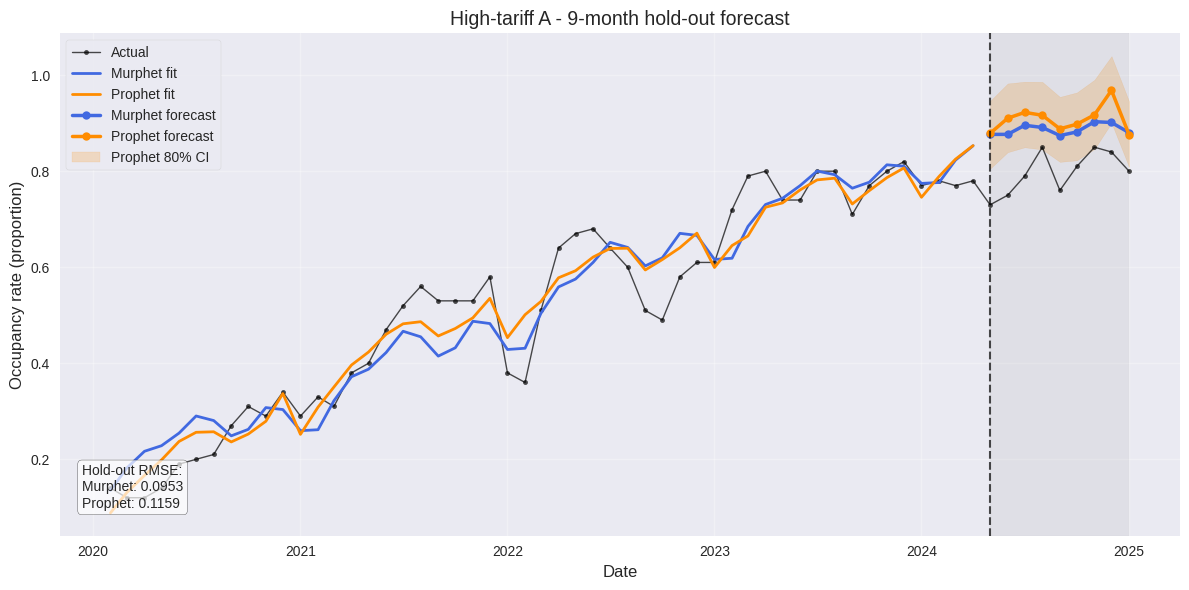

In [10]:

# --- improved visualization -------------------------------------------------
plt.style.use("seaborn-v0_8")
fig, ax = plt.subplots(figsize=(12, 6))  # Increased figure size

# Plot the full series in the background with lower opacity
ax.plot(series["ds"], series["y"], "k.-", lw=1, alpha=0.7, label="Actual")

# Plot model fits with slightly thicker lines
ax.plot(train["ds"], mur_fit.predict(train["t"]),
        color="royalblue", lw=2, label="Murphet fit")
ax.plot(train["ds"],
        prop_fit.predict(train[["ds"]])["yhat"],
        color="darkorange", lw=2, label="Prophet fit")

# Make forecast lines more visible
ax.plot(test["ds"], mur_pred, "o-", color="royalblue", markersize=6,
        lw=2.5, label="Murphet forecast")
ax.plot(test["ds"], prop_pred, "o-", color="darkorange", markersize=6,
        lw=2.5, label="Prophet forecast")

# Better confidence interval
ax.fill_between(test["ds"], prop_low, prop_upp,
                color="darkorange", alpha=0.2, label="Prophet 80% CI")

# Vertical line and improved visuals
ax.axvline(test["ds"].iloc[0], color="k", ls="--", alpha=0.7, lw=1.5)
ax.grid(True, alpha=0.3)
ax.set_title(f"High-tariff A - {HOLD_OUT_MO}-month hold-out forecast", fontsize=14)
ax.set_ylabel("Occupancy rate (proportion)", fontsize=12)
ax.set_xlabel("Date", fontsize=12)

# Better legend
ax.legend(frameon=True, fontsize=10, loc="upper left")
fig.tight_layout()

# Add shaded region for test period
ax.axvspan(test["ds"].iloc[0], test["ds"].iloc[-1], alpha=0.1, color='gray')

# Add RMSE annotation
textstr = f"Hold-out RMSE:\nMurphet: {rmse(test['y'], mur_pred):.4f}\nProphet: {rmse(test['y'], prop_pred):.4f}"
props = dict(boxstyle='round', facecolor='white', alpha=0.7)
ax.text(0.02, 0.05, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='bottom', bbox=props)